<a href="https://colab.research.google.com/github/alexander-toschev/mbzuai-course/blob/main/SplittingDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **📌 What are Train, Dev, and Test Sets?**
In **machine learning (ML) and deep learning**, datasets are **split into three parts** to train, validate, and test models effectively. This helps avoid overfitting and ensures generalization.

---

## **1️⃣ Training Set (Train)**
### **📌 Purpose**:
- The **largest** portion of the dataset.
- Used to **train** the model by adjusting weights and learning patterns.

### **📌 Characteristics**:
- Should be **diverse** and **cover all possible variations**.
- The model learns from this set but does **not evaluate** on it.

### **📌 Example**:
- If you are building a **cat vs. dog classifier**, the training set contains **labeled images of cats and dogs** so the model can learn features.

---

## **2️⃣ Development Set (Dev) / Validation Set**
### **📌 Purpose**:
- Used for **hyperparameter tuning** and **model selection**.
- Helps **prevent overfitting** by ensuring the model does not just memorize the training data.

### **📌 Characteristics**:
- The model **does not train** on this set.
- Used to **fine-tune** learning rate, model architecture, regularization, etc.
- The performance on the dev set **guides model adjustments**.

### **📌 Example**:
- If your model is **99% accurate on Train but 60% on Dev**, it means the model is **overfitting** (memorizing the training data).

---

## **3️⃣ Test Set (Test)**
### **📌 Purpose**:
- Used for **final model evaluation**.
- Represents **completely unseen data**.
- Determines the model's **real-world performance**.

### **📌 Characteristics**:
- **Never used** for training or parameter tuning.
- Measures how well the model **generalizes** to new data.

### **📌 Example**:
- After finalizing your model, you test it on **completely new images** of cats and dogs that were **not used in Train or Dev**.

---

## **📌 Summary Table**
| Set  | Purpose | Used for Training? | Used for Tuning? | Final Evaluation? |
|------|---------|------------------|------------------|------------------|
| **Train** | Learn patterns | ✅ Yes | ❌ No | ❌ No |
| **Dev (Validation)** | Tune hyperparameters | ❌ No | ✅ Yes | ❌ No |
| **Test** | Final model evaluation | ❌ No | ❌ No | ✅ Yes |

---

## **📌 Example: Dataset Split**
For **10,000 images**, a common split is:
- **Train (70%)** → 7,000 images
- **Dev (15%)** → 1,500 images
- **Test (15%)** → 1,500 images

---
## **📌 Why Split Data?**
1️⃣ **Avoid Overfitting** – The model must generalize to new data.  
2️⃣ **Tuning Hyperparameters** – Dev set prevents using Test for tuning.  
3️⃣ **Real-World Performance** – The Test set simulates real-world cases.  



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ✅ 1. Define transformations (Resize to 224x224 for ResNet-50)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ✅ 2. Load STL-10 dataset
dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)




100%|██████████| 2.64G/2.64G [08:25<00:00, 5.22MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data


In [2]:
# ✅ 3. Split into Train (70%), Dev (15%), Test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# ✅ 4. Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Train: {train_size}, Dev: {val_size}, Test: {test_size}")

from torchvision import models

# ✅ 5. Load pre-trained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# ✅ 6. Modify the last layer for STL-10 (10 classes instead of 1000)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # STL-10 has 10 classes

# ✅ 7. Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ✅ 8. Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# ✅ 9. Train the model
num_epochs = 5  # You can increase this for better accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
# ✅ 10. Function to evaluate accuracy
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# ✅ 11. Evaluate on Dev & Test sets
val_accuracy = evaluate(val_loader)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_accuracy = evaluate(test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
import numpy as np

# ✅ 12. Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



Train: 3500, Dev: 750, Test: 750


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Epoch 1, Loss: 0.7978377605026419
Epoch 2, Loss: 0.4200663161548701
Epoch 3, Loss: 0.278718006441539
Epoch 4, Loss: 0.18021239800886674
Epoch 5, Loss: 0.1617291971533136
Validation Accuracy: 81.07%
Test Accuracy: 80.80%


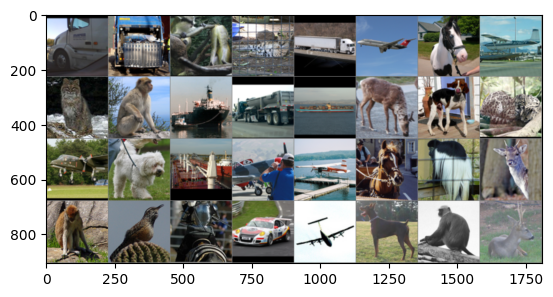

Predicted:  2 9 3 0


In [4]:
# ✅ 13. Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# ✅ 14. Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# ✅ 15. Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()))  # Move images back to CPU for display
print('Predicted: ', ' '.join(f'{predicted[j].item()}' for j in range(4)))